#### This script creates world maps of cloud bands over the northern hemisphere and southern hemispheres depicing issues of detection when setting up domains not made for cloud band detection over convergence zones 

Importation of appropriate packages

In [1]:
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

try:
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import cartopy.util as cutil
    LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
    LAT_FORMAT = LatitudeFormatter(degree_symbol="")
except ModuleNotFoundError:
    print("Cartopy is not installed. Figure will not be produced.")

warnings.filterwarnings("ignore")

from cloudbandpy.figure_tools import set_fontsize
from cloudbandpy.time_utilities import create_list_of_dates, add_startend_datetime2config

from cloudbandpy.io_utilities import (
    load_ymlfile,
    load_data_from_saved_var_files,
)

Load configuration files and data

In [2]:
# Load configuration file southern hemisphere
config_file = os.path.join("../config", "config_cbworkflow_southernhemisphere.yml")
config = load_ymlfile(config_file, isconfigfile=True)

config_south = config.copy()
config_south["saved_dirpath"] = os.path.join("../data")
config_south["startdate"] = "20210127.00"
config_south["enddate"] = "20210127.00"
config_south["load_saved_files"] = True
add_startend_datetime2config(config_south)
listofdates = create_list_of_dates(config_south)

list_of_cloud_bands_southhemisphere = load_data_from_saved_var_files(config=config_south, varname="list_of_cloud_bands")


2023-05-08 15:07:06,484 - io_utilities.load_ymlfile - INFO: Configuration file loaded
2023-05-08 15:07:06,486 - io_utilities.load_data_from_saved_var_files - INFO: Load data from: 20210127.00 to 20210127.00


In [3]:
# Load configuration file northren hemisphere
config_file2 = os.path.join("../config", "config_cbworkflow_northernhemisphere.yml")
config2 = load_ymlfile(config_file2, isconfigfile=True)

config_north = config2.copy()
config_north["saved_dirpath"] = os.path.join("../data")
config_north["startdate"] = "19980627.00"
config_north["enddate"] = "19980627.00"
# other available example: 20110626.00
config_north["load_saved_files"] = True
add_startend_datetime2config(config_north)
listofdates2 = create_list_of_dates(config_north)

list_of_cloud_bands_northhemisphere = load_data_from_saved_var_files(
    config=config_north, varname="list_of_cloud_bands")

2023-05-08 15:07:06,645 - io_utilities.load_ymlfile - INFO: Configuration file loaded
2023-05-08 15:07:06,646 - io_utilities.load_data_from_saved_var_files - INFO: Load data from: 19980627.00 to 19980627.00


In [4]:
# Create longitudes and latitudes of the two hemispheres
lons = np.arange(config["lon_west"], config["lon_east"], 0.5)
# Domain here has the same latitudinal extension as the South Pacific domain
config_south["lat_north"] = 5
config_south["lat_south"] = -50
lats_sh = np.arange(config_south["lat_south"], config_south["lat_north"] + 0.5, 0.5)[::-1]
# Domain here has the same latitudinal extension as the South Pacific domain (symmetrical)
config_north["lat_north"] = 50
config_north["lat_south"] = -5
lats_nh = np.arange(config_north["lat_south"], config_north["lat_north"] + 0.5, 0.5)

In [5]:
# Load OLR data. It will be the background of the cloud bands on the maps
filename_sh = f"../data/olrERA5_{config_south['datetime_startdate'].strftime('%Y%m%d.%H')}-{config_south['datetime_enddate'].strftime('%Y%m%d.%H')}-{config_south['domain']}.npy"
daily_variable_sh = np.load(filename_sh)[0]
daily_variable_sh, clons = cutil.add_cyclic_point(daily_variable_sh, lons)

filename_nh = f"../data/olrERA5_{config_north['datetime_startdate'].strftime('%Y%m%d.%H')}-{config_north['datetime_enddate'].strftime('%Y%m%d.%H')}-{config_north['domain']}.npy"
daily_variable_nh = np.load(filename_nh)[0]
daily_variable_nh, _ = cutil.add_cyclic_point(daily_variable_nh, lons)

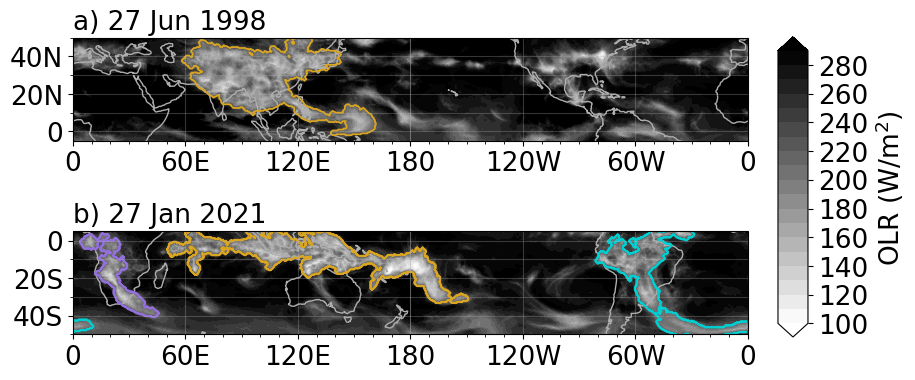

In [6]:
from matplotlib import colors


set_fontsize(size=19)
fig, ax = plt.subplots(
    ncols=1, nrows=2, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}, figsize=(10, 5)
)
cmaps = ['plasma_r', 'viridis', 'PuRd']
colors = ["goldenrod", "darkturquoise", "mediumpurple", "darkorange"]
ax[0].set_title(f"a) {config_north['datetime_startdate'].strftime('%d %b %Y')}", loc="left", color="k")
olrfill = ax[0].contourf(clons,lats_nh,daily_variable_nh,transform=ccrs.PlateCarree(),levels=range(100,300,10),cmap="binary",extend="both")
# loop over all the cloud bands of the day in the NH
for idx, icb in enumerate(list_of_cloud_bands_northhemisphere[0]):
    ax[0].contour(
        lons,
        lats_nh,
        icb.cloud_band_array,
        np.ma.masked_where(icb.cloud_band_array == 0, icb.cloud_band_array),
        transform=ccrs.PlateCarree(),
        linewidths=1.3,
        colors=colors[idx]
        # levels=range(4),
        # cmap=cmaps[idx], 
    )
ax[0].set_yticks([0, 20, 40], crs=ccrs.PlateCarree())
ax[0].yaxis.set_minor_locator(MultipleLocator(10))
ax[0].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=""))
ax[0].set_xticks([0, 60, 120, 180, 240, 300, 359.9999999999], crs=ccrs.PlateCarree())
ax[0].xaxis.set_minor_locator(MultipleLocator(10))
ax[0].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False, degree_symbol=""))
ax[0].coastlines(color="#AEAEAE")
ax[0].gridlines(draw_labels=False, alpha=0.3)

ax[1].set_title(f"b) {config_south['datetime_startdate'].strftime('%d %b %Y')}", loc="left", color="k")
ax[1].contourf(clons,lats_sh,daily_variable_sh,transform=ccrs.PlateCarree(),levels=range(100,300,10),cmap="binary",extend="both")

# loop over all the cloud bands of the day in the SH
for idx, icb in enumerate(list_of_cloud_bands_southhemisphere[0]):
    ax[1].contour(
        lons,
        lats_sh,
        icb.cloud_band_array,
        # np.ma.masked_where(icb.cloud_band_array == 0, icb.cloud_band_array),
        transform=ccrs.PlateCarree(),
        linewidths=1,
        colors=colors[idx]
        # levels=range(4),
        # cmap=cmaps[idx], 
    )
ax[1].set_yticks([0,-20, -40], crs=ccrs.PlateCarree())
ax[1].yaxis.set_minor_locator(MultipleLocator(10))
ax[1].yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=""))
ax[1].set_xticks([0, 60, 120, 180, 240, 300, 359.9999999999], crs=ccrs.PlateCarree())
ax[1].xaxis.set_minor_locator(MultipleLocator(10))
ax[1].xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False, degree_symbol=""))
ax[1].coastlines(color="#AEAEAE")
ax[1].gridlines(draw_labels=False, alpha=0.3)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.193, 0.03, 0.6])
fig.colorbar(olrfill, cax=cbar_ax)
cbar_ax.set_ylabel('OLR (W/m$^2$)', fontsize=19)

fig.subplots_adjust(wspace=0.01, hspace=0.01)

